After generating some plots yesterday, let's visualize them, following the guidelines in http://onlinelibrary.wiley.com/store/10.1002/0471142905.hg0723s81/asset/hg0723.pdf?v=1&t=jamnisjt&s=86d029167dab640c2a8a165feefb1b500ccfefd5&systemMessage=Wiley+Online+Library+usage+report+download+page+will+be+unavailable+on+Friday+24th+November+2017+at+21%3A00+EST+%2F+02.00+GMT+%2F+10%3A00+SGT+%28Saturday+25th+Nov+for+SGT+:

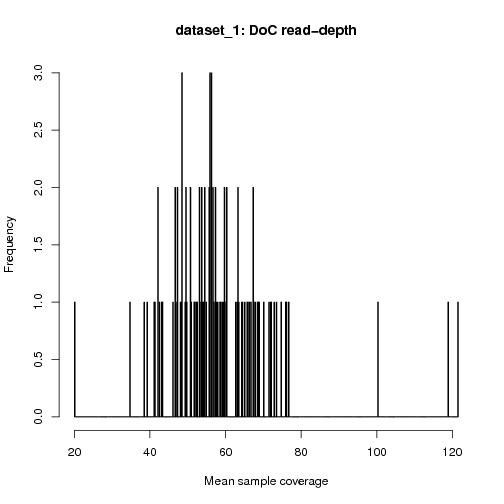

In [13]:
from IPython.display import display, Image

# used convert x y form ImageMagick in BW to go from pdf to png
display(Image('/data/NCR_SBRB/simplex/xhmm/plots/mean_sample_coverage-0.png'))

This makes sense, as our mean read depth is 50 (see cnvnator note). And I bet the sample with low coverage is the one that was dropped in the analysis... 

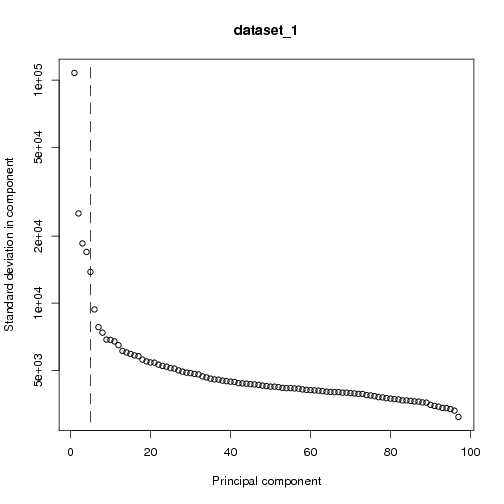

In [17]:
display(Image('/data/NCR_SBRB/simplex/xhmm/plots/PC_stddev.png'))

PCs removed are also OK, maybe even a higher number. But we should include a pedigree later if we want to learn more about the PCs, so we can make sure they capture interesting things.

----

Let's go back to the previous analysis and check if our separation among groups looks OK.

In [18]:
import vcf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

In [19]:
# figure out who is who in each trio

import glob
data_dir = '/data/NCR_SBRB/simplex/'
trios = {}
affected = []
controls = []
peds = glob.glob(data_dir + '*trio*ped')
for ped in peds:
    trio_name = ped.split('/')[-1].split('.')[0]
    fid = open(ped, 'r')
    fam = {}
    for line in fid:
        famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
        if fa != '0':
            fam['child'] = sid
            if aff == '1':
                affected.append(trio_name)
            else:
                controls.append(trio_name)
        elif sex == '1':
            fam['father'] = sid
        else:
            fam['mother'] = sid
    trios[trio_name] = fam
    fid.close()
    
fid = open('/data/NCR_SBRB/simplex/famids.txt', 'r')
fams = [t.rstrip() for t in fid]
fid.close()

# CCGO_800976 was removed during sample filtering step in XHMM
del trios['10369_trio1']
del trios['10369_trio2']
fams.remove('10369')

In [20]:
# saving the important metrics from VCFs
vcf_reader = vcf.Reader(open('/data/NCR_SBRB/simplex/xhmm/DATA.vcf', 'r'))
SQs = {}
LQs = {}
RQs = {}
NQs = {}
cnv_start, cnv_end = [], []
for sample in vcf_reader.samples:
    SQs[sample] = []
    LQs[sample] = []
    RQs[sample] = []
    NQs[sample] = []
for record in vcf_reader:
    cnv_start.append(record.start)
    cnv_end.append(record.end)
    for sample in record.samples:
        SQs[sample.sample].append(sample.data.SQ)
        LQs[sample.sample].append(sample.data.LQ)
        RQs[sample.sample].append(sample.data.RQ)
        NQs[sample.sample].append(sample.data.NQ)

For the disruptive criteria, we'll need to know which records have start or end within a gene transcript:

In [21]:
annot = pd.read_table('/data/NCR_SBRB/simplex/xhmm/annotated_targets.refseq.loci',
                      names=['window', 'nannot', 'names'], header=None)
trans_start, trans_end = [], []
for pos, nannot in zip(annot.window, annot.nannot):
    if nannot > 0:
        start, end = pos.split(':')[-1].split('..')
        trans_start.append(int(start))
        trans_end.append(int(end))
trans_start = np.array(trans_start)
trans_end = np.array(trans_end)

left_transcript, right_transcript = [], []
for l, r in zip(cnv_start, cnv_end):
    left_transcript.append(np.any((trans_start < l) & (trans_end > l)))
    right_transcript.append(np.any((trans_start < r) & (trans_end > r)))
left_transcript = np.array(left_transcript)
right_transcript = np.array(right_transcript)

In [22]:
quality = np.arange(10, 100, 10)
ntrios = len(trios)
trans_rate = np.zeros([ntrios, len(quality)])
denovo = np.zeros([ntrios, len(quality)])
disruptive_dnm = np.zeros([ntrios, len(quality)])
disruptive_inh = np.zeros([ntrios, len(quality)])
cnvs = np.zeros([ntrios, len(quality)])
for q, qual in enumerate(quality):
    qual_prime = qual / 2.0
    for t, trio in enumerate(trios.keys()):
        some_deletion = np.any(np.array(SQs[trios[trio]['child']]) >= qual,
                               axis=1)
        cnvs[t, q] = np.sum(some_deletion)
        
        # denovo criteria
        mom_diploid = np.any(np.array(NQs[trios[trio]['mother']]) >= qual,
                             axis=1)
        dad_diploid = np.any(np.array(NQs[trios[trio]['father']]) >= qual,
                             axis=1)
        child_dnms = np.logical_and(some_deletion,
                                    np.logical_and(mom_diploid, dad_diploid))
        denovo[t, q] = np.sum(child_dnms)
        
        # transmitted criteria
        mom_deletion = np.any(np.array(SQs[trios[trio]['mother']]) >= qual,
                              axis=1)
        mom_source = np.logical_and(mom_deletion, dad_diploid)
        dad_deletion = np.any(np.array(SQs[trios[trio]['father']]) >= qual,
                              axis=1)
        dad_source = np.logical_and(dad_deletion, mom_diploid)
        transmitted = np.logical_or(np.logical_and(mom_source, some_deletion),
                                    np.logical_and(dad_source, some_deletion))
        
        child_diploid = np.any(np.array(NQs[trios[trio]['child']]) >= qual,
                               axis=1)
        not_transmitted = np.logical_or(np.logical_and(mom_source,
                                                       child_diploid),
                                        np.logical_and(dad_source,
                                                       child_diploid))
        trans_rate[t, q] = float(np.sum(transmitted)) / (np.sum(transmitted) +
                                                         np.sum(not_transmitted))
        
        # disruptive criteria
        good_left = np.any(np.array(LQs[trios[trio]['child']]) >= qual_prime,
                           axis=1)
        good_right = np.any(np.array(RQs[trios[trio]['child']]) >= qual_prime,
                            axis=1)
        in_gene = np.logical_and(np.logical_or(good_left, good_right),
                                 np.logical_or(left_transcript, right_transcript))
        idx = np.logical_and(child_dnms, in_gene)
        disruptive_dnm[t, q] = np.sum(idx)
        idx = np.logical_and(transmitted, in_gene)
        disruptive_inh[t, q] = np.sum(idx)

([<matplotlib.axis.XTick at 0x2aab06371210>,
 <a list of 9 Text xticklabel objects>)

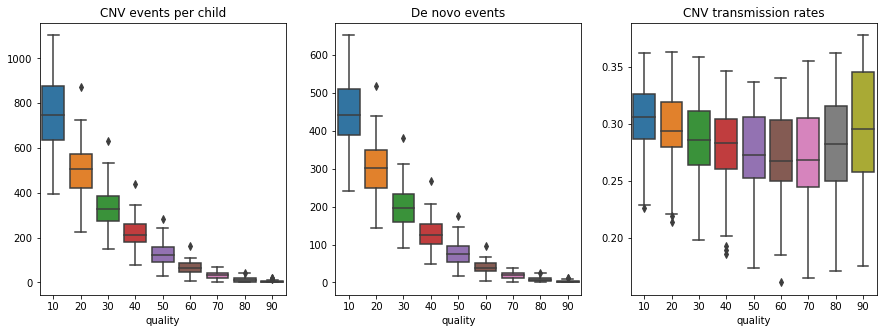

In [23]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data=[disruptive_dnm[:, q] + disruptive_inh[:, q] for q in range(len(quality))], orient='v')
plt.xlabel('quality')
plt.title('CNV events per child')
plt.xticks(range(len(quality)), quality)

plt.subplot(1, 3, 2)
sns.boxplot(data=[disruptive_dnm[:, q] for q in range(len(quality))], orient='v')
plt.xlabel('quality')
plt.title('De novo events')
plt.xticks(range(len(quality)), quality)

plt.subplot(1, 3, 3)
sns.boxplot(data=[trans_rate[:, q] for q in range(len(quality))], orient='v')
plt.xlabel('quality')
plt.title('CNV transmission rates')
plt.xticks(range(len(quality)), quality)

This seems a bit high still, even at quality threshold of 60. Like, median DNM of 50? We can play with this more later. 

In [24]:
quality = np.arange(10, 100, 10)
means = np.zeros([3, len(quality)])
for q, qual in enumerate(quality):
    aff = []
    unaff_pair = []
    unaff_all = []
    for fam in fams:
        # this family only has an affected trio
        if fam != '10042':
            keys = [k for k in trios.iterkeys() if k.find(fam)==0]
            keys.sort()
            k = [k for k in range(len(trios.keys())) if trios.keys()[k] == keys[0]]
            aff.append(disruptive_dnm[k[0], q])
            k = [k for k in range(len(trios.keys())) if trios.keys()[k] == keys[1]]
            unaff_pair.append(disruptive_dnm[k[0], q])
            for mykey in keys[1:]:
                k = [k for k in range(len(trios.keys())) if trios.keys()[k] == mykey]
                unaff_all.append(disruptive_dnm[k[0], q])
    means[0, q] = np.mean(aff)
    means[1, q] = np.mean(unaff_pair)
    means[2, q] = np.mean(unaff_all)

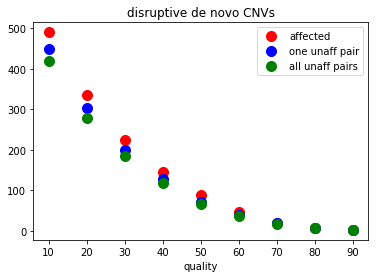

In [25]:
plt.figure()
plt.plot(quality, means[0, :], '.', color='r', markersize=20)
plt.plot(quality, means[1, :], '.', color='b', markersize=20)
plt.plot(quality, means[2, :], '.', color='g', markersize=20)
plt.legend(['affected', 'one unaff pair', 'all unaff pairs'])
plt.xlabel('quality')
plt.title('disruptive de novo CNVs')

Are they statistically significant?

In [26]:
quality = np.arange(10, 100, 10)
from scipy import stats
rel_ps = []
wilcoxon_ps = []
for q, qual in enumerate(quality):
    x, y = [], []
    for fam in fams:
        # this family only has an affected trio
        if fam != '10042':
            keys = [k for k in trios.iterkeys() if k.find(fam)==0]
            keys.sort()
            k = [k for k in range(len(trios.keys())) if trios.keys()[k] == keys[0]]
            x.append(disruptive_dnm[k[0], q])
            k = [k for k in range(len(trios.keys())) if trios.keys()[k] == keys[1]]
            y.append(disruptive_dnm[k[0], q])
    stat, pval = stats.wilcoxon(x, y)
    wilcoxon_ps.append(pval)
    stat, pval = stats.ttest_rel(x, y)
    rel_ps.append(pval)
print 'Only one pair per family:'
print 'Nonparametric:', wilcoxon_ps
print 'T-test:', rel_ps

ttest_ps = []
mann_ps = []
for q, qual in enumerate(quality):
    x, y = [], []
    for fam in fams:
        # this family only has an affected trio
        if fam != '10042':
            keys = [k for k in trios.iterkeys() if k.find(fam)==0]
            keys.sort()
            k = [k for k in range(len(trios.keys())) if trios.keys()[k] == keys[0]]
            x.append(disruptive_dnm[k[0], q])
            for mykey in keys[1:]:
                k = [k for k in range(len(trios.keys())) if trios.keys()[k] == mykey]
                y.append(disruptive_dnm[k[0], q])
    stat, pval = stats.mannwhitneyu(x, y)
    mann_ps.append(pval)
    stat, pval = stats.ttest_ind(x, y)
    ttest_ps.append(pval)
print 'All pairs:'
print 'Non-parametric:', mann_ps
print 'T-test:', ttest_ps

Only one pair per family:
Nonparametric: [0.070128236871877928, 0.083556366675359581, 0.11186004073658172, 0.16481498744990153, 0.064122415497433194, 0.17102205287629391, 0.62902344943296062, 0.861577160346924, 0.79287321599221217]
T-test: [0.23764378375007739, 0.23547973161928734, 0.24191452323790191, 0.25661338025097347, 0.16167183236070187, 0.31105140149251315, 0.76514621594480459, 0.85380278060503512, 0.70663381773267164]
All pairs:
Non-parametric: [0.0068446795486283088, 0.010469899532885737, 0.017492164855610573, 0.018449901165532391, 0.0098440027359465582, 0.079811001869023568, 0.2696033600551242, 0.31922894453921491, 0.41363523064325219]
T-test: [0.017168117501190676, 0.019194019275482085, 0.030507403107781782, 0.038820911107562361, 0.025465402458775346, 0.10161143463501088, 0.43708042225898402, 0.57980063039312357, 0.89683859834044533]


The higher quality we demand, the less significant it gets. Not good. Let's just make sure we're running this correctly. We pick a couple offsprings with denovo mutations and make sure all criteria are met:

In [35]:
t = 0
print disruptive_dnm[t, 8]
print trios[trios.keys()[t]]

2.0
{'mother': 'CLIA_400147', 'father': 'CLIA_400150', 'child': 'CLIA_400148'}


So, this kid has 2 CNVs matching the disruptive denovo criteria at Q >= 90. Is that true?

In [55]:
qual = 90
trio = trios.keys()[0]
some_deletion = np.any(np.array(SQs[trios[trio]['child']]) >= qual,
                       axis=1)
print 'Some deletion:', np.sum(some_deletion)
        
mom_diploid = np.any(np.array(NQs[trios[trio]['mother']]) >= qual,
                     axis=1)
dad_diploid = np.any(np.array(NQs[trios[trio]['father']]) >= qual,
                     axis=1)
child_dnms = np.logical_and(some_deletion,
                            np.logical_and(mom_diploid, dad_diploid))
print 'De novo:', np.sum(child_dnms)
        
good_left = np.any(np.array(LQs[trios[trio]['child']]) >= qual_prime,
                   axis=1)
good_right = np.any(np.array(RQs[trios[trio]['child']]) >= qual_prime,
                    axis=1)
in_gene = np.logical_and(np.logical_or(good_left, good_right),
                         np.logical_or(left_transcript, right_transcript))
print 'In gene:', np.sum(in_gene)
idx = np.logical_and(child_dnms, in_gene)
print 'CNV denovo in gene:', np.sum(idx)
for i in np.nonzero(idx)[0]:
    print 'start:', cnv_start[i], 'end:', cnv_end[i]

Some deletion: 824
De novo: 348
In gene: 7
CNV denovo in gene: 2
start: 49490484 end: 49490489
start: 49490484 end: 49490489


This is getting a bit cumbersome... their protocol paper suggests analysis with plink/seq, so let's try that instead in a different notebook.

# TODO:

* make sure that the whole disruptive gene thingy is working properly (look at figures)
* better to run PCA within groups? are controls biasing the results? check literature. might need ot run other tools instead
* number of rare denovo CNVs present only in affected trio, and compare it to numbers only in unaffected trio!
* check different parameters in HMM to end up with less CNVs
* if we add the brain to this, instead of doing nv vs adhd contrast, could we do brain correlations?
* incorporate multiplex samples in the analysis